In [1]:
%%capture
!pip install iterative-stratification
#!pip uninstall tensorflow-addons -y
#!pip install git+https://github.com/tensorflow/addons.git

In [2]:
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy('mixed_float16')

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
#import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import RMSprop,Adam,SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121, MobileNetV2, EfficientNetB1, VGG19, InceptionV3
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, BatchNormalization,Dropout,Flatten,Input,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import F1Score

import warnings
warnings.filterwarnings('ignore')
import gc

gc.collect()
tf.keras.backend.clear_session()

E0000 00:00:1749097441.306215      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749097441.381145      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# ===== Config =====
IMG_SIZE = (240, 240)
#IMG_SIZE =  (224,224) #vgg
#IMG_SIZE =  (299,299) #inceptionv3
BATCH_SIZE = 32
EPOCHS = 20
NUM_CLASSES = 7
IMAGE_DIR = '/kaggle/input/my-seminar-dataset/wfd_dataset/wfd_dataset'  # Change if your images are elsewhere
data_path = '/kaggle/input/my-seminar-dataset/data.csv'

In [5]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import pandas as pd
import numpy as np


def load_data(data_path,
             display_first = 0):
    
    data = pd.read_csv(data_path)
    
    ids = data['img'].str.split('_').apply(lambda x: x[1])
    data.drop(columns = ['img'],inplace=True)
    data.insert(0,'id',ids)
    
    # shuffle
    data = data.sample(frac=1, random_state=42).reset_index(drop=True)

    # splitting 
    X = data["id"].values
    Y = data.iloc[:, 1:].values  # All label columns
    
    print(f"Total datapoints we have = {len(X)}")
    
    # First split: Train (70%) vs Temp (30%)
    mskf = MultilabelStratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    for train_index, temp_index in mskf.split(X, Y):
        X_train, X_temp = X[train_index], X[temp_index]
        Y_train, Y_temp = Y[train_index], Y[temp_index]
        break 
    
    # Second split: Temp → Val (15%) and Test (15%)
    X_temp_df = pd.DataFrame(X_temp, columns=["id"])
    Y_temp_df = pd.DataFrame(Y_temp, columns=data.columns[1:])
    temp_df = pd.concat([X_temp_df, Y_temp_df], axis=1)
    
    mskf_temp = MultilabelStratifiedKFold(n_splits=2, shuffle=True, random_state=42)
    for val_index, test_index in mskf_temp.split(X_temp_df.values, Y_temp_df.values):
        X_val, X_test = X_temp[val_index], X_temp[test_index]
        Y_val, Y_test = Y_temp[val_index], Y_temp[test_index]
        break
    
    # Create final DataFrames
    data_train = data[data["id"].isin(X_train)].reset_index(drop=True)
    data_valid = data[data["id"].isin(X_val)].reset_index(drop=True)
    data_test  = data[data["id"].isin(X_test)].reset_index(drop=True)
    
    print(f"My training set has = {data_train.shape[0]} examples.")
    print(f"My test set has = {data_test.shape[0]} examples.")
    print(f"My valid set has = {data_valid.shape[0]} examples.")

    if display_first != 0:
        display(data_train.head(display_first))
        display(data_test.head(display_first))

    return (data_train, data_valid, data_test)

In [6]:
data_train, data_valid, data_test = load_data(data_path)

Total datapoints we have = 2414
My training set has = 1606 examples.
My test set has = 410 examples.
My valid set has = 398 examples.


## Visualization

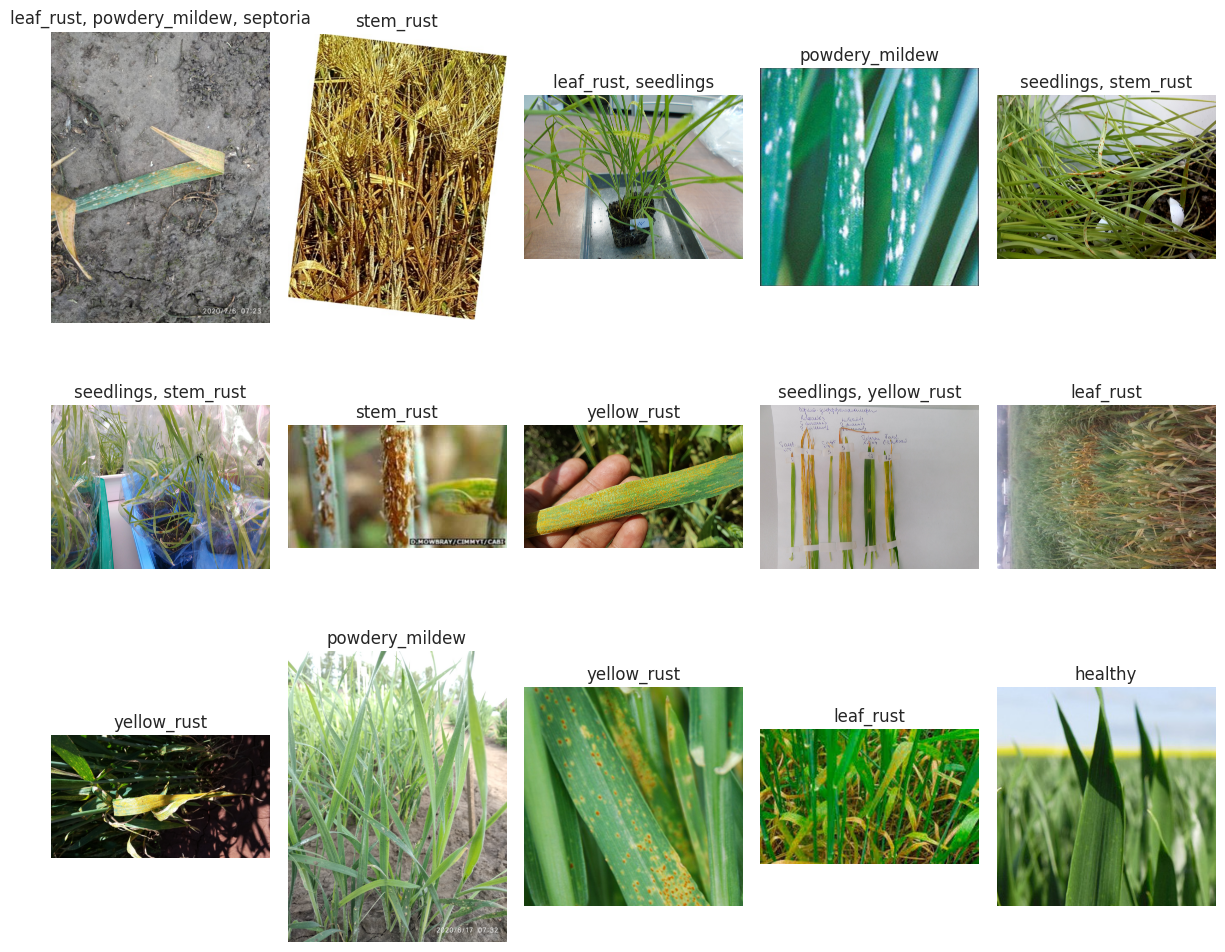

In [33]:
import random
import numpy as np
random.seed(42)
import os
from PIL import Image

labels = data_train.columns[1:]

def get_labels(row):
    return [label for label in labels if row[label] == 1]

N = 15
nth = data_train.sample(N)

IMG_DIR_F = '/kaggle/input/my-seminar-dataset/wfd_dataset/wfd_dataset'

def display_samples(img_dir_f,mdf, n=9):
    plt.figure(figsize=(12, 10))

    for i, (_, row) in enumerate(mdf.iterrows()):
        img_path = os.path.join(img_dir_f, row["id"])
        img = Image.open(img_path).convert("RGB")

        plt.subplot(3, 5, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(", ".join(get_labels(row)))

    plt.tight_layout()
    plt.show()


display_samples(IMG_DIR_F,nth, N)


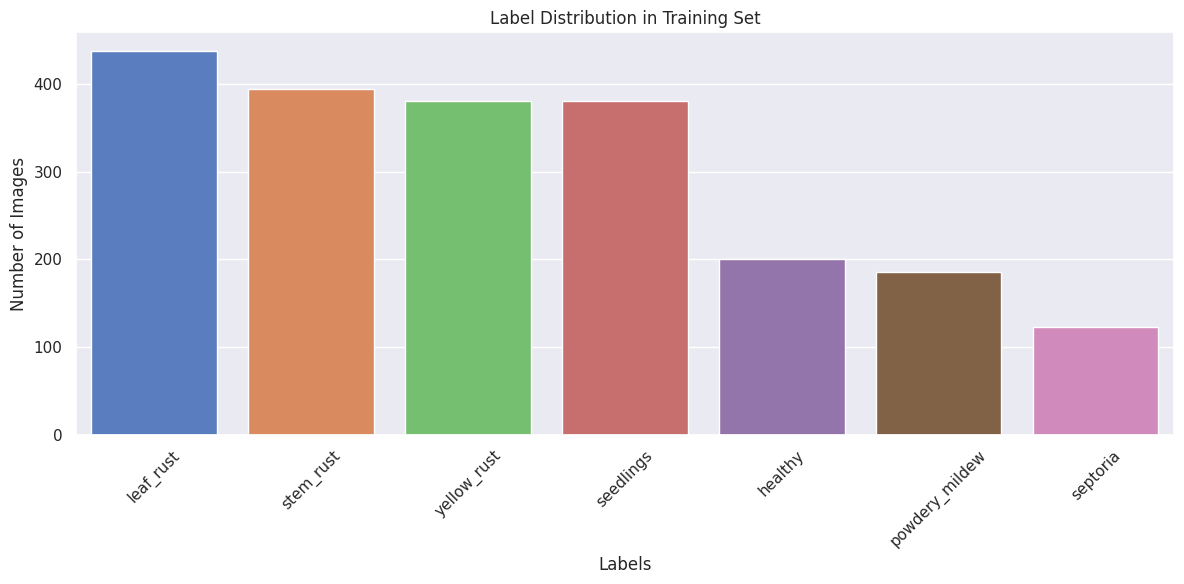

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set()


train_d = data_train.drop(columns=['id'])

label_counts = train_d.sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="muted")
plt.xticks(rotation=45)
plt.xlabel("Labels")
plt.ylabel("Number of Images")
plt.title("Label Distribution in Training Set")
plt.tight_layout()
plt.show()


## Data Augmentation for minority classes

here i can see that, the disease types: `powerdary mildew`,`healthy`, `septoria` are minority in class.
so we can either<br>
1) extend their classes examples in train set with external data
2) do augmentations. e.g. rotate, shift etc.

In [8]:
mctrain  = data_train[['id','healthy','powdery_mildew','septoria']].copy()
mctrain  = mctrain.set_index('id')
mctrain.sum()

healthy           200
powdery_mildew    185
septoria          123
dtype: int64

we will import some external data from kaggle here: https://www.kaggle.com/datasets/kushagra3204/wheat-plant-diseases

we will extract only the images that are required

In [48]:
import os
from tqdm import tqdm
import pandas as pd

def get_ext_data(EXT_IMG_DIR_PATH,tag, num = 5):
    img_paths = [os.path.join(EXT_IMG_DIR_PATH,f) for f in os.listdir(EXT_IMG_DIR_PATH) if f.endswith(('jpeg','.jpg','.png'))]

    img_paths = img_paths[:num]
    new_df2 = pd.DataFrame(columns = data_train.columns[1:])

    images = []
    
    for path in tqdm(img_paths):
        fn = path.split("/")[-1]
        img = cv2.imread(path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append((fn, img))

            new_df2.loc[fn,tag] = 1
            
    new_df2.reset_index(names='id',inplace=True)
    new_df2 = new_df2.fillna(0)

    return new_df2, images
    


Lets get the required data and corresponding dataframe

In [57]:
healthly_img_path = "/kaggle/input/wheat-plant-diseases/data/train/Healthy"
required_no_of_imgs = 165
tag = "healthy"

healthy_new_df, healthy_images = get_ext_data(healthly_img_path, 
                                              tag = tag, 
                                              num = required_no_of_imgs)

100%|██████████| 165/165 [00:09<00:00, 18.23it/s]


In [58]:
pm_img_path = "/kaggle/input/wheat-plant-diseases/data/train/Mildew"
required_no_of_imgs = 210
tag1 = "powdery_mildew"

pm_new_df, pm_images = get_ext_data(pm_img_path, 
                                  tag = tag1, 
                                  num = required_no_of_imgs)

100%|██████████| 210/210 [00:02<00:00, 77.62it/s] 


In [59]:
sep_img_path = "/kaggle/input/wheat-plant-diseases/data/train/Septoria"
required_no_of_imgs = 300
tag2 = "septoria"

sep_new_df, sep_images = get_ext_data(sep_img_path, 
                                  tag = tag2, 
                                  num = required_no_of_imgs)

100%|██████████| 300/300 [00:11<00:00, 25.27it/s]


In [61]:
all_new_images = healthy_images
all_new_images.extend(pm_images)
all_new_images.extend(sep_images)

len(all_new_images)

675

In [75]:
import os
import cv2
from tqdm import tqdm

save_dir = "/kaggle/working/augmented_images"  
os.makedirs(save_dir, exist_ok=True)


for filename, image in tqdm(all_new_images,desc="Images saved: "):
    save_path = os.path.join(save_dir, filename.replace('.png', '.jpg'))
    
    bgr_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    # Save image
    cv2.imwrite(save_path, bgr_image)

Images saved: 100%|██████████| 675/675 [00:06<00:00, 104.27it/s]


In [95]:
df_new = pd.DataFrame(columns = data_train.columns[1:])

df_new = pd.concat([healthy_new_df, pm_new_df, sep_new_df])
df_new['id'] = df_new['id'].apply(lambda x: f"{x.split('.')[0]}.jpg")

csv_path = "/kaggle/working/augmented_train_3labels.csv"
df_new.to_csv(csv_path, index=False)

In [96]:
!zip -r /kaggle/working/augmented_images.zip /kaggle/working/augmented_images

  adding: kaggle/working/augmented_images/ (stored 0%)
  adding: kaggle/working/augmented_images/septoria_685.jpg (deflated 0%)
  adding: kaggle/working/augmented_images/mildew_351.jpg (deflated 0%)
  adding: kaggle/working/augmented_images/septoria_520.jpg (deflated 0%)
  adding: kaggle/working/augmented_images/septoria_1124.jpg (deflated 0%)
  adding: kaggle/working/augmented_images/healthy_66.jpg (deflated 4%)
  adding: kaggle/working/augmented_images/septoria_991.jpg (deflated 0%)
  adding: kaggle/working/augmented_images/mildew_624.jpg (deflated 1%)
  adding: kaggle/working/augmented_images/healthy_841.jpg (deflated 0%)
  adding: kaggle/working/augmented_images/mildew_119.jpg (deflated 8%)
  adding: kaggle/working/augmented_images/septoria_1042.jpg (deflated 0%)
  adding: kaggle/working/augmented_images/mildew_1052.jpg (deflated 1%)
  adding: kaggle/working/augmented_images/healthy_761.jpg (deflated 0%)
  adding: kaggle/working/augmented_images/healthy_33.jpg (deflated 5%)
  addin

In [19]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt

# # Create a random grayscale image
# array = np.random.randint(0, 256, (300, 300), dtype=np.uint8)

# # Display the image using matplotlib

# array_rgb = cv2.cvtColor(images[1], cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# plt.imshow(array_rgb, cmap='gray')  # Use 'gray' for grayscale images
# plt.axis('off')  # Hide axes
# plt.show()

In [9]:
ext_aug_data_df = pd.read_csv("/kaggle/input/wcdc-ext/augmented_train_3labels.csv")
new_data_train = pd.concat([data_train,ext_aug_data_df])

print(f"Old train_data examples {data_train.shape[0]}\nAugmented train_data examples {new_data_train.shape[0]}\n\n+{new_data_train.shape[0] - data_train.shape[0]} new examples added!")

Old train_data examples 1606
Augmented train_data examples 2281

+675 new examples added!


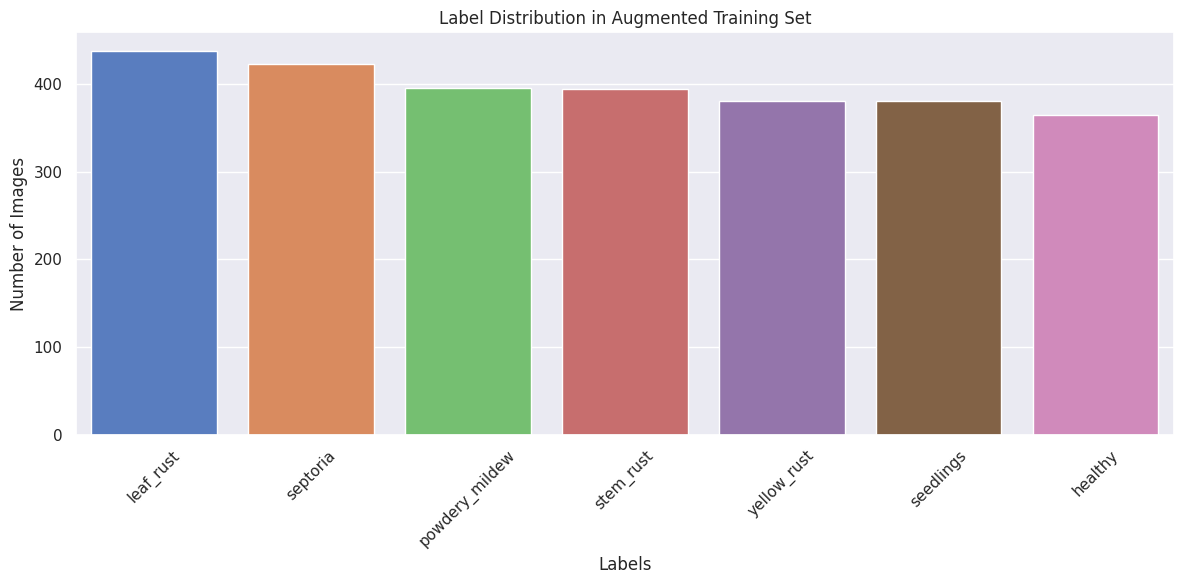

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set()


new_train_d = new_data_train.drop(columns=['id'])

new_label_counts = new_train_d.sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=new_label_counts.index, y=new_label_counts.values, palette="muted")
plt.xticks(rotation=45)
plt.xlabel("Labels")
plt.ylabel("Number of Images")
plt.title("Label Distribution in Augmented Training Set")
plt.tight_layout()
plt.show()

In [11]:
def preprocess(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.cast(img, tf.float32) / 255.0
        return img, label

AUG_IMAGE_DIR = '/kaggle/input/wcdc-ext/augmented_images'


def map_img_to_path(filename):
    filename = str(filename)
    if filename.startswith(('septoria','healthy','mildew')):
        return os.path.join(AUG_IMAGE_DIR,filename)
    return os.path.join(IMAGE_DIR,filename)
    

def df_to_dataset(df, is_train=True):
    image_paths = df['id'].apply(map_img_to_path).values
    labels = df.iloc[:, 1:].values.astype('float32')  # Skip 'id' column

    
    ds = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(image_paths), labels))
    
    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if is_train:
        ds = ds.shuffle(1000)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Model Building

In [12]:
train_ds = df_to_dataset(new_data_train, is_train=True)
val_ds = df_to_dataset(data_valid, is_train=False)
test_ds = df_to_dataset(data_test, is_train=False)

I0000 00:00:1749097460.250464      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [13]:
combined_ds = train_ds.concatenate(val_ds)
combined_ds = combined_ds.unbatch()
combined_ds = combined_ds.shuffle(buffer_size=5000, reshuffle_each_iteration=False)

total_count = len(new_data_train) + len(data_valid)
split_index = int(0.8 * total_count)

train_ds = combined_ds.take(split_index).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = combined_ds.skip(split_index).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [14]:
# ===== Build Model =====
def build_model(model_name,img_size):
    if model_name == "DenseNet121":
        base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(*img_size, 3))
    elif model_name == "ResNet50":
        base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(*img_size, 3))
    elif model_name == "EfficientNetB1":
        base_model = EfficientNetB1(include_top=False, weights='imagenet', input_shape=(*img_size, 3))
    elif model_name == "MobileNetV2":
        base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(*img_size, 3))
    elif model_name == "VGG19":
        base_model = VGG19(include_top=False, weights='imagenet', input_shape=(*img_size, 3))
    elif model_name == "InceptionV3":
        base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(*img_size, 3))
    else:
        raise "No suitable model found"
        
    
    base_model.trainable = False  # Freeze for transfer learning

    inputs = Input(shape=(*img_size, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(NUM_CLASSES, activation='sigmoid')(x) 
    return Model(inputs, outputs)


#from tensorflow.keras.mixed_precision import LossScaleOptimizer


def DiseaseClassifier(model_name, 
                      train_epochs,
                      num_classes,
                      callbacks,
                      img_size):

    # opt = tf.keras.optimizers.Adam(1e-4)
    # opt = mixed_precision.LossScaleOptimizer(opt)


    model = build_model(model_name=model_name,
                        img_size=img_size)

    # ===== Compile =====
    model.compile(
        optimizer='adam',
        #optimizer = opt,
        loss='binary_crossentropy',
        #loss=binary_focal_loss(gamma=2.0, alpha=0.25),
        metrics=[
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.F1Score(average='micro',name='f1_micro')  # or 'micro'
    
        ]
    )

    # ===== Train =====
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=train_epochs,
        callbacks=callbacks
    )

    return model, history


def evaluate_model(train_ds, val_ds, test_ds, model):
    
    # ==== Test =====
    train_results = model.evaluate(train_ds)
    val_results = model.evaluate(val_ds)
    test_results = model.evaluate(test_ds)

    res_df_noft = {
        'loss':[],
        'precision':[],
        'recall':[],
        'f1_micro':[]
    }

    for my_res_noft in [train_results,val_results, test_results]:
        res_df_noft['loss'].append(my_res_noft[0])
        res_df_noft['precision'].append(my_res_noft[1])
        res_df_noft['recall'].append(my_res_noft[2])
        res_df_noft['f1_micro'].append(my_res_noft[3])
    

    res_df_noft = pd.DataFrame(res_df_noft)
    res_df_noft = res_df_noft.apply(lambda x: round(x*100,2))
    return res_df_noft


#import tensorflow_addons as tfa
#'/kaggle/input/densenet121_new/tensorflow2/default/1/best_model_DenseNet121_new.h5',

# ====== Reloading model  ==========
from tensorflow.keras.models import load_model

def load_from_local(model_path):
    return load_model(
        model_path,
        custom_objects={
            "F1Score": tf.keras.metrics.F1Score(average='micro')
        }
    )


def finetune(model,
             train_ds,
             val_ds,
             callbacks, 
             ft_lr = 1e-5, ft_epochs = 10, num_classes = 7):


    model.get_layer(index=1).trainable = True  # Unfreeze base model
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(ft_lr),
        loss='binary_crossentropy',
        metrics=[
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.F1Score(average='micro', name='f1_micro')
        ]
    )
    ft_history = model.fit(train_ds, validation_data=val_ds, epochs=ft_epochs, callbacks=callbacks)

    return model, ft_history

## TL with DenseNet21

In [28]:
MODEL_NAME = 'DenseNet121'

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
    ModelCheckpoint('aug_best_model_DenseNet121.h5', save_best_only=True),
     #MicroPrecisionCallback(val_ds)
]

print(f"PERFORMING TRANSFER LEARNING FOR '{MODEL_NAME}'")
denseNet_trained,denseNet_history = DiseaseClassifier(
    model_name=MODEL_NAME,
    train_epochs= EPOCHS,
    num_classes=NUM_CLASSES,
    callbacks=callbacks,
    img_size=IMG_SIZE
)

result_df = evaluate_model(
    model = denseNet_trained,
    train_ds = train_ds,
    val_ds = val_ds,
    test_ds = test_ds
)

result_df

PERFORMING TRANSFER LEARNING FOR 'DenseNet121'
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


I0000 00:00:1749065229.100273     108 service.cc:148] XLA service 0x7ef8c0002fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749065229.101094     108 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749065231.855200     108 cuda_dnn.cc:529] Loaded cuDNN version 90300


      2/Unknown 101s 64ms/step - f1_micro: 0.2543 - loss: 0.7488 - precision: 0.2025 - recall: 0.4291

I0000 00:00:1749065242.913310     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


67/67 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - f1_micro: 0.2788 - loss: 0.5154 - precision: 0.3528 - recall: 0.1699 - val_f1_micro: 0.5154 - val_loss: 0.3416 - val_precision: 0.8491 - val_recall: 0.2971 - learning_rate: 0.0010
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 109s 860ms/step - f1_micro: 0.4535 - loss: 0.3648 - precision: 0.6772 - recall: 0.3163 - val_f1_micro: 0.5953 - val_loss: 0.2871 - val_precision: 0.8316 - val_recall: 0.4712 - learning_rate: 0.0010
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 109s 869ms/step - f1_micro: 0.5389 - loss: 0.3187 - precision: 0.7522 - recall: 0.4230 - val_f1_micro: 0.6207 - val_loss: 0.2683 - val_precision: 0.8163 - val_recall: 0.5375 - learning_rate: 0.0010
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 107s 853ms/step - f1_micro: 0.5604 - loss: 0.3021 - precision: 0.7596 - recall: 0.4642 - val_f1_micro: 0.6576 - val_loss: 0.2477 - val_precision: 0.8650 - val_recall: 0.5348 - learning_rate: 0.0010
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 103s 776ms/step - f1_micro: 0.56

,loss,precision,recall,f1_micro
0,14.57,91.95,80.61,78.56
1,16.00,89.81,77.54,77.32
2,23.11,79.41,66.35,63.88


## FL with DenseNet21

In [15]:
from keras.models import load_model
model = load_model('/kaggle/input/suf_aug_densenet121_tl/tensorflow2/default/1/suf_aug_best_model_DenseNet121_TL.h5')

In [18]:
evaluate_model(train_ds, val_ds, test_ds, model)

I0000 00:00:1749097734.536205     100 service.cc:148] XLA service 0x7b3e0c089e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749097734.537242     100 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749097735.788707     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


      3/Unknown 87s 62ms/step - f1_micro: 0.7709 - loss: 0.1697 - precision: 0.8497 - recall: 0.7088

I0000 00:00:1749097745.809698     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


67/67 ━━━━━━━━━━━━━━━━━━━━ 101s 211ms/step - f1_micro: 0.7839 - loss: 0.1506 - precision: 0.9053 - recall: 0.7895
17/17 ━━━━━━━━━━━━━━━━━━━━ 63s 669ms/step - f1_micro: 0.7675 - loss: 0.1511 - precision: 0.9230 - recall: 0.8059
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - f1_micro: 0.6430 - loss: 0.2339 - precision: 0.7933 - recall: 0.6688


,loss,precision,recall,f1_micro
0,14.83,91.58,80.05,78.18
1,15.78,90.81,77.76,77.19
2,23.11,79.41,66.35,63.88


In [20]:
MODEL_NAME = 'DenseNet121'
FT_EPOCHS = 10
FT_LR = 1e-5

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
    ModelCheckpoint(f'suf_aug_best_model_{MODEL_NAME}_FT.h5', save_best_only=True),
     #MicroPrecisionCallback(val_ds)
]

ft_model, _ = finetune(
    model,
    train_ds,
    val_ds,
    callbacks,
    ft_lr = FT_LR,
    ft_epochs=FT_EPOCHS
)

evaluate_model(train_ds, val_ds, test_ds, ft_model)

Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step - f1_micro: 0.4346 - loss: 0.4600 - precision: 0.5387 - recall: 0.4471 - val_f1_micro: 0.7362 - val_loss: 0.1560 - val_precision: 0.8722 - val_recall: 0.7734 - learning_rate: 1.0000e-05
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 113s 980ms/step - f1_micro: 0.5077 - loss: 0.3634 - precision: 0.6474 - recall: 0.5184 - val_f1_micro: 0.7189 - val_loss: 0.1590 - val_precision: 0.8528 - val_recall: 0.7822 - learning_rate: 1.0000e-05
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 117s 986ms/step - f1_micro: 0.5626 - loss: 0.3041 - precision: 0.7164 - recall: 0.5703 - val_f1_micro: 0.7361 - val_loss: 0.1592 - val_precision: 0.8785 - val_recall: 0.7737 - learning_rate: 1.0000e-05
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 112s 991ms/step - f1_micro: 0.6169 - loss: 0.2545 - precision: 0.7462 - recall: 0.6134 - val_f1_micro: 0.7695 - val_loss: 0.1481 - val_precision: 0.8891 - val_recall: 0.7842 - learning_rate: 1.0000e-05
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 148s 

,loss,precision,recall,f1_micro
0,7.99,95.24,90.84,84.77
1,9.62,92.72,88.98,82.47
2,18.48,82.77,74.38,68.60


## Conclution of this trial:

Risks Introduced<br>
1) *Domain Shift*:
<br>
Differences in background, light, and camera angle could be causing the model to perform worse on original-style test data.
<br>
The drop in test F1 from 71.38 => 68.6 before and after augmentation is likely due to this.
<br><br>
2) Overfitting to "clean" samples:
<br>
The model may now favor detecting symptoms in cleaner, well-lit settings, struggling when they’re obscured in messy real-world images.
<br>
